In [1]:
# Install kaggle library
!pip install kaggle

# Upload kaggle.json
from google.colab import files
files.upload()  # Pilih file kaggle.json dari komputermu

# Pindahkan ke direktori yang benar dan atur permission
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
# Ganti URL ini dengan URL dataset pilihanmu dari Kaggle
!kaggle datasets download -d farzadnekouei/trash-type-image-dataset

Dataset URL: https://www.kaggle.com/datasets/farzadnekouei/trash-type-image-dataset
License(s): unknown
  0% 0.00/40.9M [00:00<?, ?B/s]
100% 40.9M/40.9M [00:00<00:00, 766MB/s]


In [3]:
# Ekstrak file ZIP
!unzip trash-type-image-dataset.zip -d sampah

Archive:  trash-type-image-dataset.zip
  inflating: sampah/TrashType_Image_Dataset/cardboard/cardboard_001.jpg  
  inflating: sampah/TrashType_Image_Dataset/cardboard/cardboard_002.jpg  
  inflating: sampah/TrashType_Image_Dataset/cardboard/cardboard_003.jpg  
  inflating: sampah/TrashType_Image_Dataset/cardboard/cardboard_004.jpg  
  inflating: sampah/TrashType_Image_Dataset/cardboard/cardboard_005.jpg  
  inflating: sampah/TrashType_Image_Dataset/cardboard/cardboard_006.jpg  
  inflating: sampah/TrashType_Image_Dataset/cardboard/cardboard_007.jpg  
  inflating: sampah/TrashType_Image_Dataset/cardboard/cardboard_008.jpg  
  inflating: sampah/TrashType_Image_Dataset/cardboard/cardboard_009.jpg  
  inflating: sampah/TrashType_Image_Dataset/cardboard/cardboard_010.jpg  
  inflating: sampah/TrashType_Image_Dataset/cardboard/cardboard_011.jpg  
  inflating: sampah/TrashType_Image_Dataset/cardboard/cardboard_012.jpg  
  inflating: sampah/TrashType_Image_Dataset/cardboard/cardboard_013.jpg  

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import shutil
import random
import os

In [5]:
# Path ke folder asli
source_dir = '/content/sampah/TrashType_Image_Dataset/'
target_dir = 'dataset'  # Folder baru hasil split

splits = ['train', 'val', 'test']
split_ratio = {'train': 0.7, 'val': 0.15, 'test': 0.15}

# Buat struktur folder baru
for split in splits:
    for class_name in os.listdir(source_dir):
        os.makedirs(os.path.join(target_dir, split, class_name), exist_ok=True)

# Copy dan split gambar
for class_name in os.listdir(source_dir):
    imgs = os.listdir(os.path.join(source_dir, class_name))
    random.shuffle(imgs)

    n_total = len(imgs)
    n_train = int(n_total * split_ratio['train'])
    n_val = int(n_total * split_ratio['val'])

    split_data = {
        'train': imgs[:n_train],
        'val': imgs[n_train:n_train + n_val],
        'test': imgs[n_train + n_val:]
    }

    for split in splits:
        for img_name in split_data[split]:
            src = os.path.join(source_dir, class_name, img_name)
            dst = os.path.join(target_dir, split, class_name, img_name)
            shutil.copyfile(src, dst)

print("✅ Dataset berhasil dipisah!")


✅ Dataset berhasil dipisah!


In [6]:
from torchvision import transforms

transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [7]:
from torchvision import datasets
from torch.utils.data import DataLoader

data_dir = 'dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True)
               for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [8]:
from torchvision import models
import torch.nn as nn
import torch

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Ubah layer terakhir
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 122MB/s]


In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np

num_epochs = 10
train_acc_history, val_acc_history = [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_corrects_train = 0

    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_corrects_train += torch.sum(preds == labels.data)

    train_acc = running_corrects_train.double() / len(image_datasets['train'])
    train_acc_history.append(train_acc.item())

    # Validasi
    model.eval()
    running_corrects_val = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects_val += torch.sum(preds == labels.data)

    val_acc = running_corrects_val.double() / len(image_datasets['val'])
    val_acc_history.append(val_acc.item())

    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/10
Train Acc: 0.4881 | Val Acc: 0.6525
Epoch 2/10
Train Acc: 0.6648 | Val Acc: 0.7215
Epoch 3/10
Train Acc: 0.7276 | Val Acc: 0.7401
Epoch 4/10
Train Acc: 0.7458 | Val Acc: 0.7639
Epoch 5/10
Train Acc: 0.7860 | Val Acc: 0.7825
Epoch 6/10
Train Acc: 0.7780 | Val Acc: 0.7560
Epoch 7/10
Train Acc: 0.7882 | Val Acc: 0.7798
Epoch 8/10
Train Acc: 0.7950 | Val Acc: 0.7613
Epoch 9/10
Train Acc: 0.7984 | Val Acc: 0.7984
Epoch 10/10
Train Acc: 0.8086 | Val Acc: 0.7931


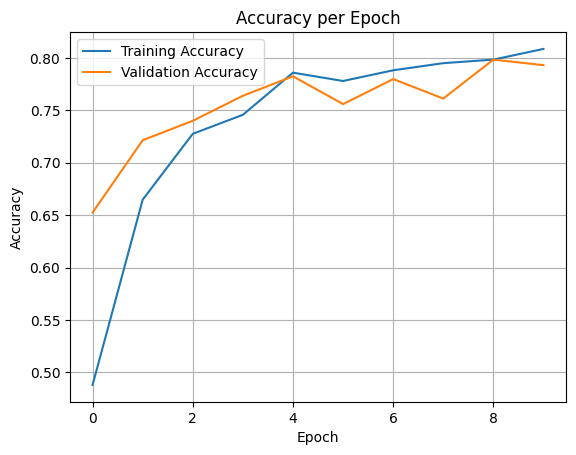

In [11]:
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

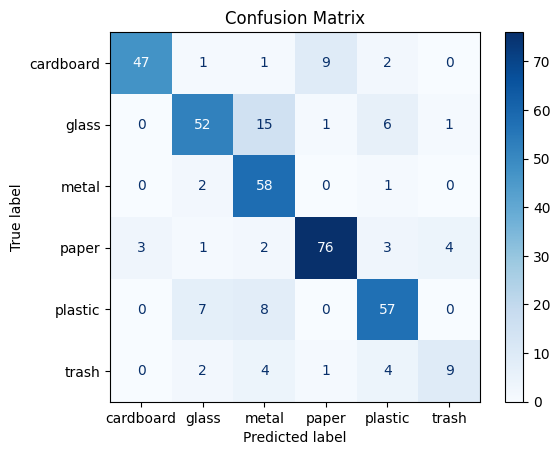

Classification Report:
              precision    recall  f1-score   support

   cardboard       0.94      0.78      0.85        60
       glass       0.80      0.69      0.74        75
       metal       0.66      0.95      0.78        61
       paper       0.87      0.85      0.86        89
     plastic       0.78      0.79      0.79        72
       trash       0.64      0.45      0.53        20

    accuracy                           0.79       377
   macro avg       0.78      0.75      0.76       377
weighted avg       0.80      0.79      0.79       377



In [12]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [13]:
torch.save(model.state_dict(), 'sampah.pth')

print("Model saved as sampah.pth")

Model saved as sampah.pth


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Predicted: metal | Confidence: 0.66
Predicted: trash | Confidence: 0.36
Predicted: paper | Confidence: 0.89


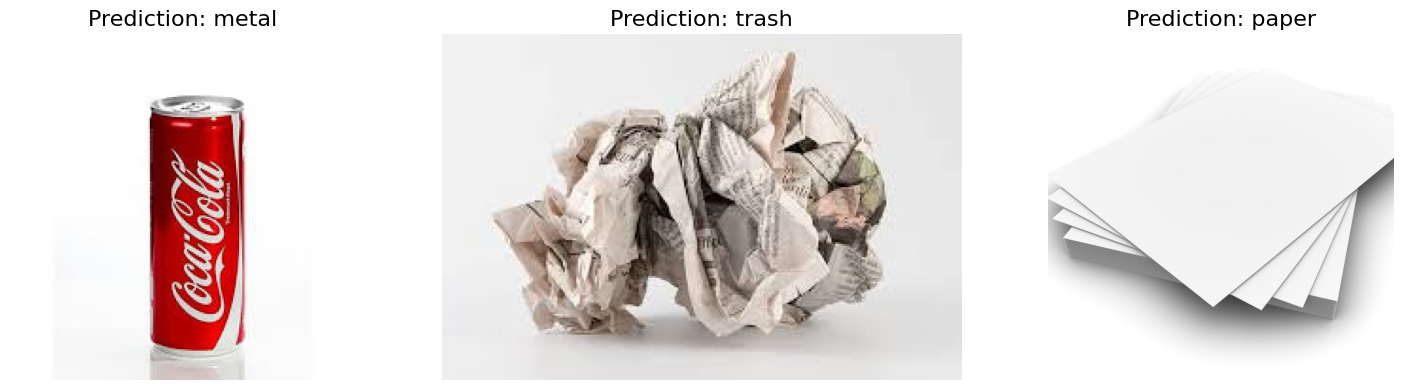

In [17]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 1. Load Model
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 6)  # Ganti 6 sesuai jumlah kelas kamu
model.load_state_dict(torch.load('sampah.pth', map_location=torch.device('cpu')))
model.eval()

# 2. Sesuaikan label (ganti sesuai urutan dataset kamu)
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# 3. Fungsi prediksi tunggal
def predict_image(img_path, model, class_names):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    img = Image.open(img_path).convert('RGB')
    img_t = transform(img).unsqueeze(0)

    with torch.no_grad():
        output = model(img_t)
        probs = torch.nn.functional.softmax(output[0], dim=0)
        predicted_idx = torch.argmax(probs).item()
        predicted_label = class_names[predicted_idx]
        confidence = probs[predicted_idx].item()

    print(f"Predicted: {predicted_label} | Confidence: {confidence:.2f}")
    return predicted_label, img

# 4. Path gambar prediksi
img_paths = [
    '/content/images.jpeg',
    '/content/images (1).jpeg',
    '/content/61OorFhm6SL.jpg'
]

plt.figure(figsize=(16, 4))  # Atur ukuran keseluruhan figure

for i, path in enumerate(img_paths):  # Iterate through img_paths, not img_path
    predicted_label, image_to_show = predict_image(path, model, class_names)

    # 5. Tampilkan hasil prediksi
    plt.subplot(1, len(img_paths), i + 1) # Use img_paths to get the total number of images
    plt.imshow(image_to_show) # Use image_to_show for displaying
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label}", fontsize=16)

plt.tight_layout()
plt.show() # Show all subplots at once